# New Yorker Data Science Challenge

### Prepared by John Tindel as a part of the interview process for the position of Data Scientist

For this challenge, I was given a large amount of Yelp data and asked to use data science techniques to produce an interesting project. 

One thing that I've always found fascinating is the evolution of language over time, how certain words or expressions come into and fall out of favor with the public. Why is the word 'groovy' no longer used to describe satisfaction or pleasure with a particular thing? What causes some words to fall out of favor, and how quickly does that happen? 

I think it would be interesting to look at the Yelp dataset and see if there is a trend in what words people use to express happiness/unhappiness with their business experience over time. Are there any words that people use now that weren't commonly used 10 years ago? What words were formerly used that are no longer in fashion? 

The Yelp dataset is great for this, as it is a very large dataset (over 2.5 million reviews), and it is already classified by sentiment using the star system. My plan here is to take a decent-sized sample of reviews for each year, perform some NLP techniques to parse the text into a form appropriate for classification, then use a classifier on each year's data to see which words were most strongly predictive of negative and positive reviews in each year. At the end, I should be able to compare how each word's use has changed over time. This dataset contains sufficient data for 10 years of analysis; a dataset with a longer time frame would be likelier to show signficant changes, but this should be sufficient to show some change. 

Before we start this, be sure that you have your environment correctly configured. You will need MongoDB for this to run correctly; running the setup scripts and building the docker file should cover everything, but this will not work without running the setup steps described in the repo's README.

Now, let's create a couple of classes here. First, we'll need a class for each review object. We're interested in the star rating and the review text, and we can build a lemmatization (returning a word to its basic form, as in 'seen' becomes 'see', therefore removing distinctions the algorithm would make about different versions of the same word)/punctuation removal function into that. Second, we'll build a class for a set of reviews, taking in the number of reviews to query, the year for which the query will be made, and returning a datset sorted into features/labels. After that, we can move on to our train/test step. 

One other thing to note here is that I'm going to be excluding 3-star reviews for this project, as we're only interested in two types of reviews: positive and negative. Since it's unclear if a 3-star review is negative or positive, they will be excluded from this dataset.

In [5]:
from pymongo import MongoClient
import string
from spacy.en import English

parser = English()

class review():
    
    def __init__(self, review_doc):
        self.text = self.process_text(review_doc['text'])
        self.parsed = self.parse(self.text)
        self.lemmatized = self.lemmatize(self.parsed)
        self.stars = review_doc['stars']

    def process_text(self, string_input):
        table = str.maketrans({key: None for key in string.punctuation})
        return string_input.translate(table).lower()

    def parse(self, text):
        try:
            return parser(text)
        except:
            return None

    def lemmatize(self, parsed):
        try:
            output = []
            for token in parsed:
                output.append(token.lemma_)
            return ' '.join(i for i in output)
        except:
            return None
        

class reviewSet():

    def __init__(self, number_of_reviews, year):
        self.client = MongoClient()
        self.db = self.client.newYorkerTest
        self.reviews = self.db.reviews
        self.raw = self.pull_reviews(number_of_reviews, year)
        self.features, self.labels = self.separate(self.raw)
        self.dict = {'features':self.features, 'labels':self.labels}

    def pull_reviews(self, num, year):
        outList = []
        query = {'date':{'$gte': str(year) + '-01-01', '$lt': str(year) + '-12-31'},'stars':{'$ne':3}}
        for i in self.reviews.find(query).limit(num):
            outList.append(review(i))
        return outList

    def separate(self, raw):
        features = []
        labels = []
        for i in raw: 
            features.append(i.lemmatized)
            if i.stars >=4:
                labels.append(1)
            else:
                labels.append(0)
        return features, labels

With our classes in place, let's take a year's worth of data, train a classifier on it, and then decide if the classifier meets our needs. Since reviews vary widely in length, we'll be using a TF-IDF vectorizer. For our model, we're going to try a Linear Support Vector Machine using the L2 penalty and a squared loss function. Gradient descent classifiers might be a good choice for classifying here as well, but we'll only be able to get the most informative features if we use a linear classification model. 

In [6]:
test_data = reviewSet(5000, 2015)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

x_train = vectorizer.fit_transform(test_data.dict['features'][:4000])
x_test = vectorizer.transform(test_data.dict['features'][4000:])
y_train = test_data.dict['labels'][:4000]
y_test = test_data.dict['labels'][4000:]

from sklearn.svm import LinearSVC

classifier = LinearSVC(loss = 'squared_hinge', penalty = 'l2', dual = False)

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

from sklearn import metrics
print('Accuracy:  ' + str(metrics.accuracy_score(predictions, y_test)))
print('Precision: ' + str(metrics.average_precision_score(predictions, y_test)))
print('F1 Score:  ' + str(metrics.f1_score(predictions, y_test))) 
print('Recall:    ' + str(metrics.recall_score(predictions, y_test)))

Accuracy:  0.911
Precision: 0.963556080068
F1 Score:  0.937979094077
Recall:    0.92955801105


At 91% accuracy, I'm satisfied with the quality of this classifier. Now let's build a function to return the words most strongly associated with negative and positive reviews.

In [12]:
import numpy as np

def neg_pos_words(vectorizer, classifier):
    feature_names = vectorizer.get_feature_names()
    top10 = np.argsort(classifier.coef_[0])[-10:]
    bottom10 = np.argsort(classifier.coef_[0])[:10]
    positive_words = (feature_names[j] for j in top10)
    negative_words = (feature_names[j] for j in bottom10)
    return positive_words, negative_words

pos, neg = neg_pos_words(vectorizer, classifier)

print('Positive-correlated words: 2015')
for i in pos:
    print(i)
    
print('_______________________________')
print('Negative-correlated words: 2015')
for i in neg:
    print(i)
    

Positive-correlated words: 2015
definitely
awesome
perfect
favorite
delicious
love
excellent
best
amazing
great
_______________________________
Negative-correlated words: 2015
rude
disappointing
disappointed
bland
ok
terrible
horrible
awful
bad
poor


I'm pretty satisfied with how the classifier is working based on these informative features: they're precisely the types of words I'd list as probably being predictive of a negative vs. positive review. Now, let's go through all of the reviews we have from 2006-2016 and see if/how these trends change over time. For each year, I'm going to be taking a sample of 10000 reviews; a larger sample is possible, but if I'm already getting such a strong classifier from a smaller sample of just 5000 reviews, I think a 10000-review sample should be sufficiently large. My hunch is that some of the words will remain pretty constantly popular over time, but I'm hoping that a few words will pop up as being more popular/less popular at different points in our dataset. 

In [16]:
by_year_dict = {}
for year in range(2006, 2017):
    sub_dict = {}
    dataset = reviewSet(10000, year)
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    x = vectorizer.fit_transform(dataset.dict['features'])
    y = dataset.dict['labels']
    classifier = LinearSVC(loss = 'squared_hinge', penalty = 'l2', dual = False)
    classifier.fit(x, y)
    pos, neg = neg_pos_words(vectorizer, classifier)
    sub_dict['positive'] = list(pos)
    sub_dict['negative'] = list(neg)
    sub_dict['n_samples'] = len(dataset.dict['features'])
    by_year_dict[year] = sub_dict

In [18]:
import pprint

pprint.pprint(by_year_dict[2006]['positive'])

pprint.pprint(by_year_dict[2016]['positive'])

['hot',
 'awesome',
 'fun',
 'friendly',
 'excellent',
 'amazing',
 'favorite',
 'best',
 'great',
 'love']
['perfect',
 'definitely',
 'awesome',
 'happy',
 'excellent',
 'best',
 'love',
 'amazing',
 'delicious',
 'great']


Already we can see a difference between the 2006 and 2016 datasets: the word 'hot' is at the top of the positive words for 2006, but is nowhere to be found in 2016. Let's do some graphing to see how this relationship plays out over time. For this, we'll first put it all into a pandas dataframe so that it's a bit easier to work with. We'll end up with two dataframes: one for the positive words and one for the negative words. We can then move on to plotting them. Note that I'm only going to plot the dataframes with more than one observation, as it'll otherwise show up as an empty plot.

In [49]:
import pandas as pd

def convert_to_df(dictionary):
    pos = []
    neg = []
    for key, value in dictionary.items():
        year = key
        for i in range(0, 9):
            pos.append([year, value['positive'][i], i])
            neg.append([year, value['negative'][i], i])
    return pd.DataFrame(pos, columns = ['year', 'word', 'strength']), pd.DataFrame(neg, columns = ['year', 'word', 'strength'])

positive, negative = convert_to_df(by_year_dict)

positive.head(10)        

,year,word,strength
0,2016,perfect,0
1,2016,definitely,1
2,2016,awesome,2
3,2016,happy,3
4,2016,excellent,4
5,2016,best,5
6,2016,love,6
7,2016,amazing,7
8,2016,delicious,8
9,2006,hot,0


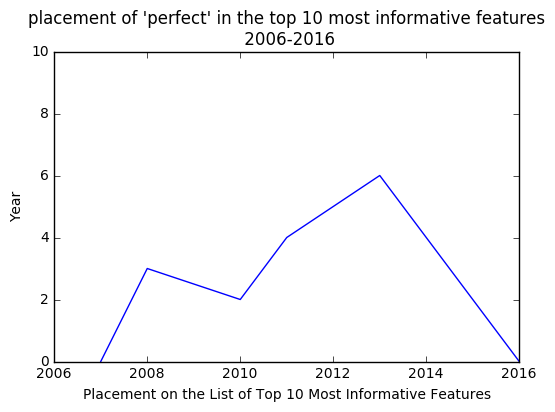

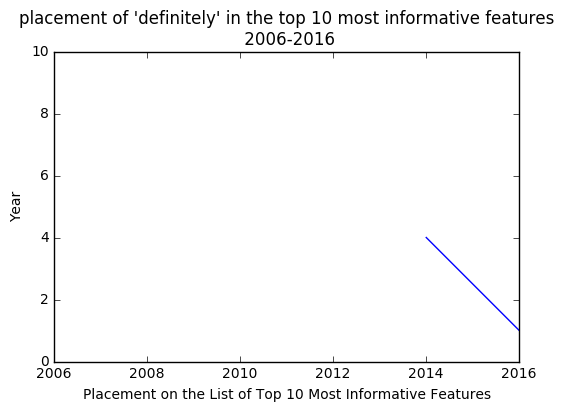

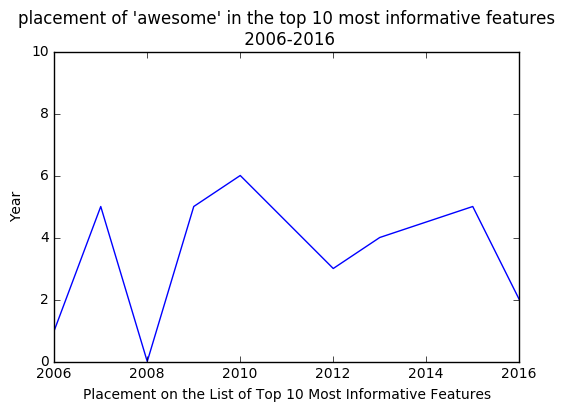

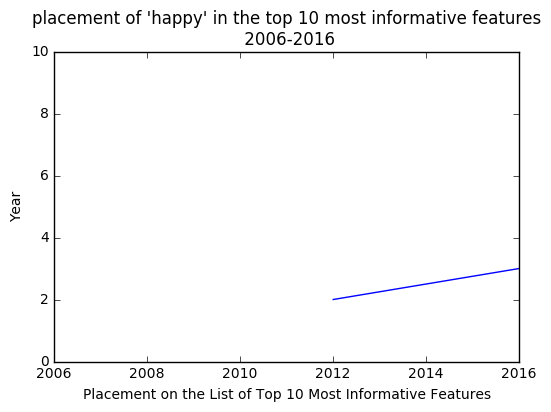

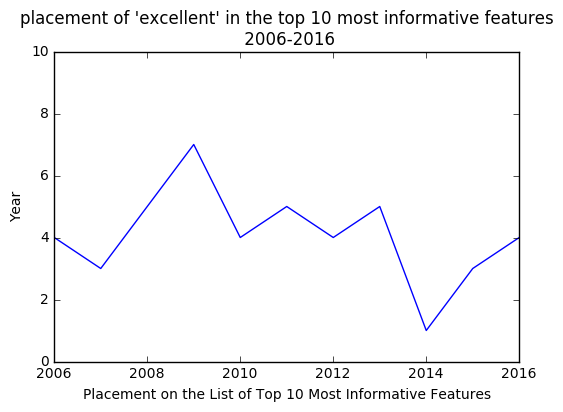

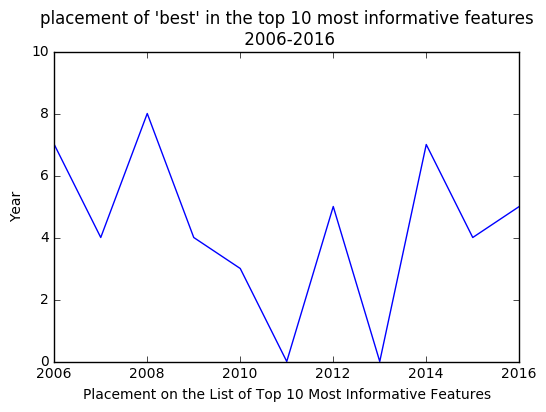

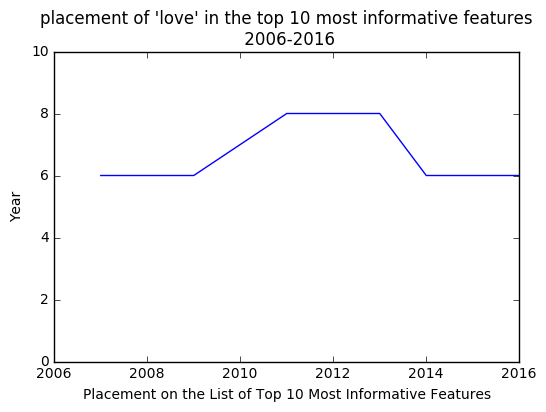

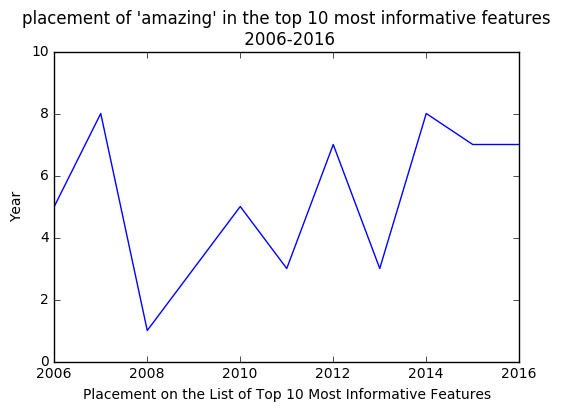

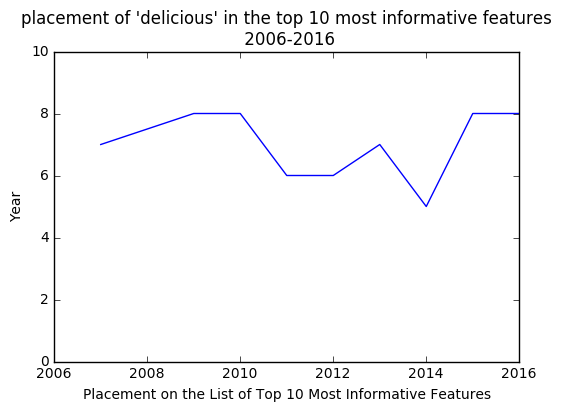

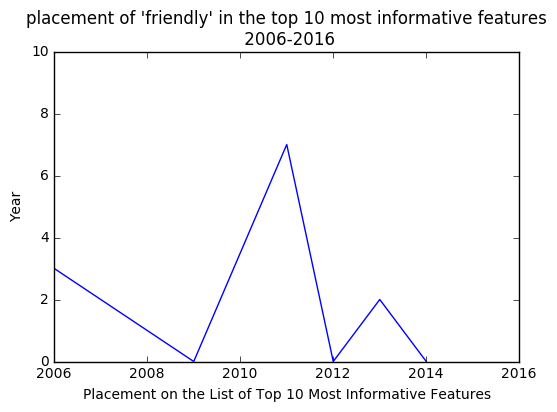

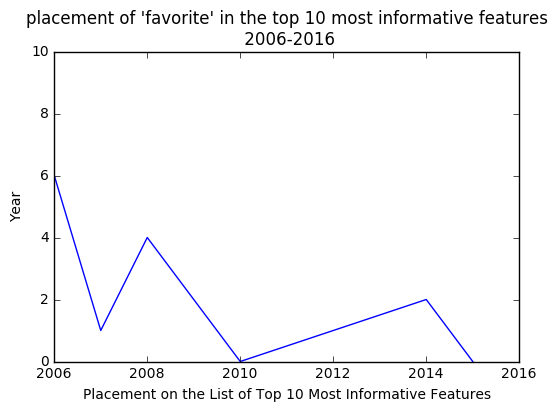

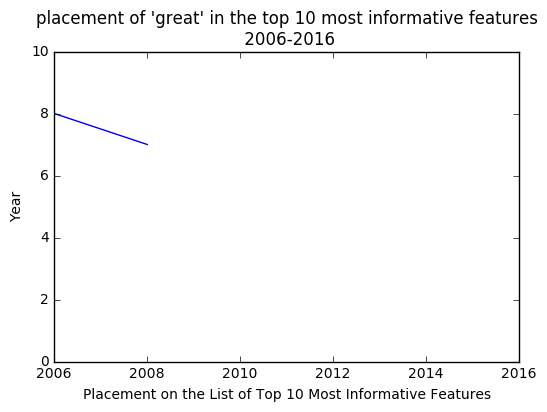

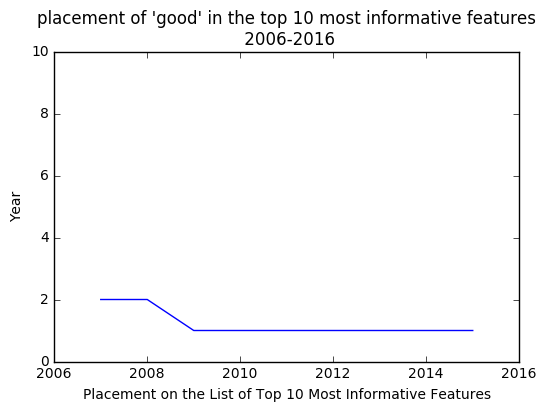

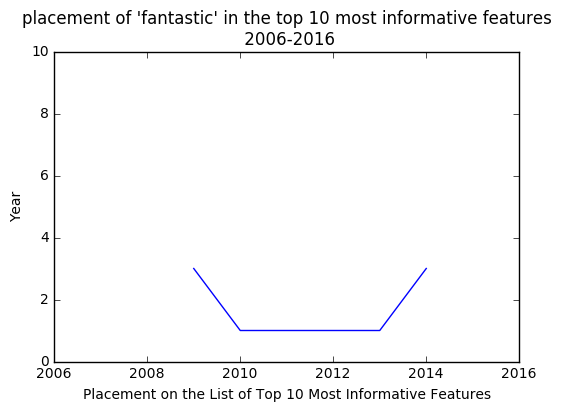

In [62]:
import matplotlib.pyplot as plt

#Need to invert the 'strength' measure, as it's currently showing the most informative word as a '0'
positive['strength'] = 10 - positive.strength
negative['strength'] = 10 - negative.strength

for word in positive.word.unique():
    sub_df = positive[positive.word == word]
    sub_df = sub_df.sort_values(by = 'year')
    if sub_df.shape[0] > 1:
        plt.plot(sub_df.year, sub_df.strength, label = word)
        plt.xlabel('Placement on the List of Top 10 Most Informative Features')
        plt.ylabel('Year')
        plt.xlim([2006,2016])
        plt.ylim([0, 10])
        plt.title('placement of \'' + word + '\' in the top 10 most informative features\n 2006-2016')
        plt.show()
    else:
        continue


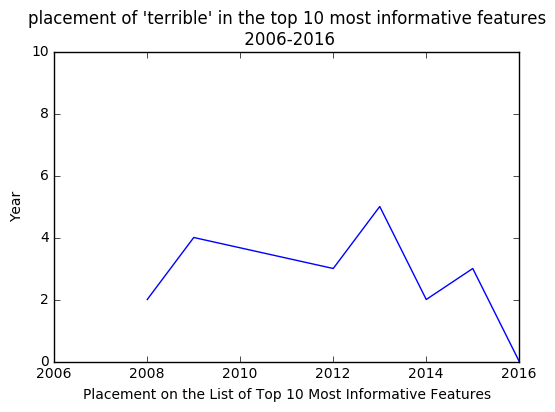

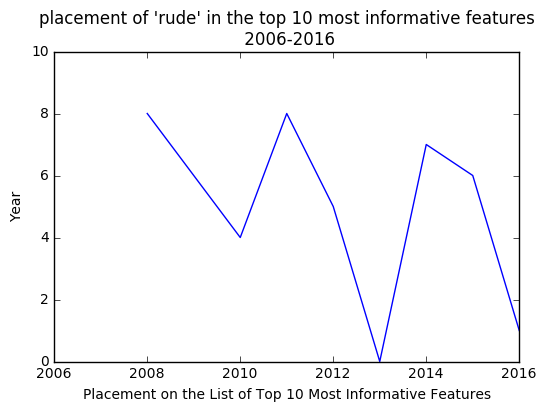

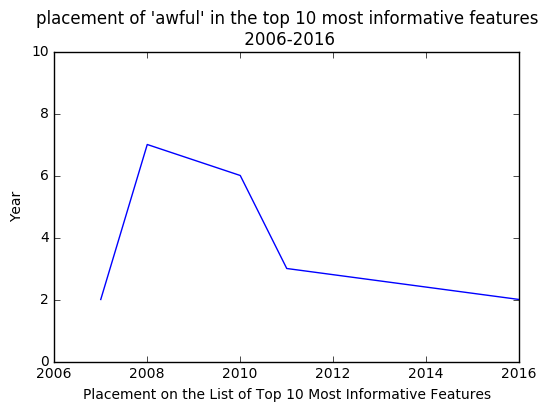

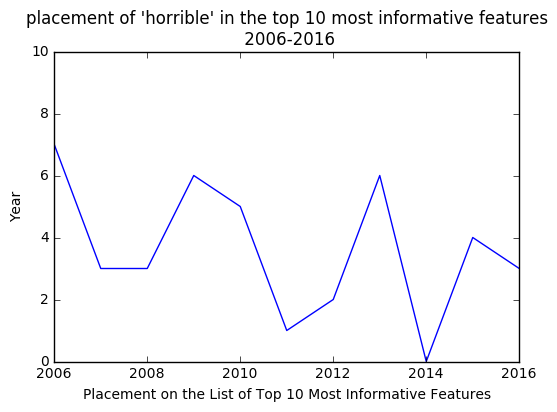

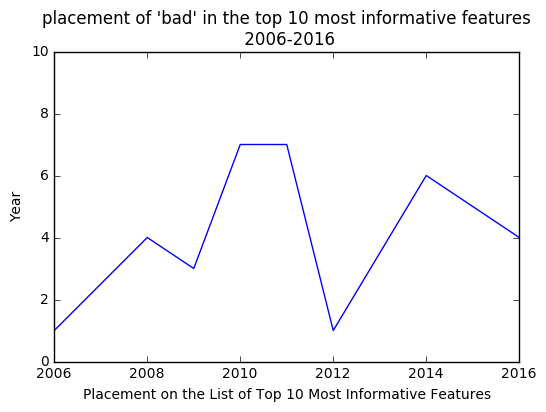

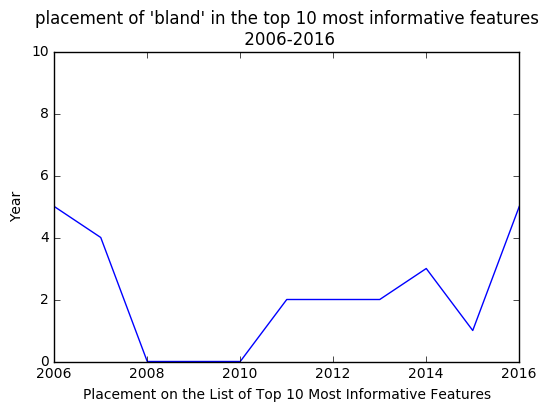

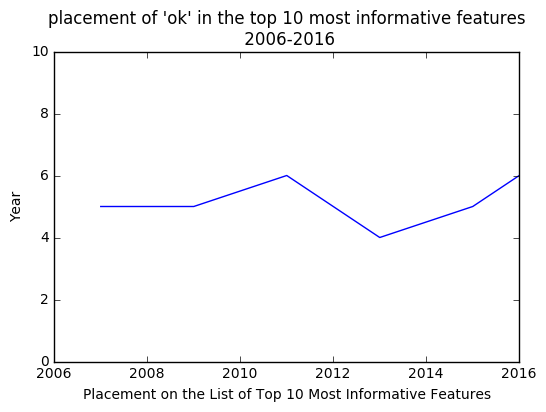

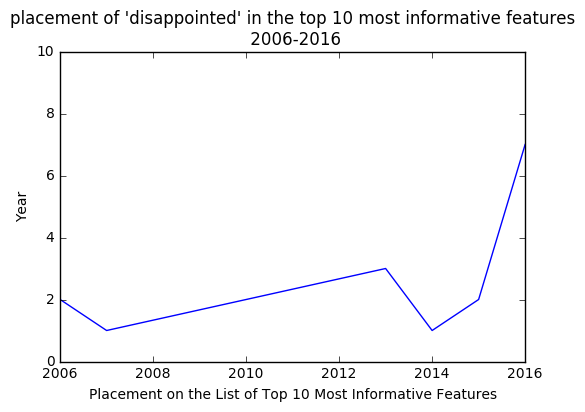

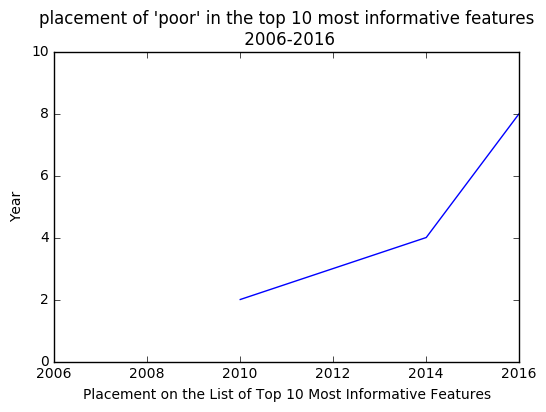

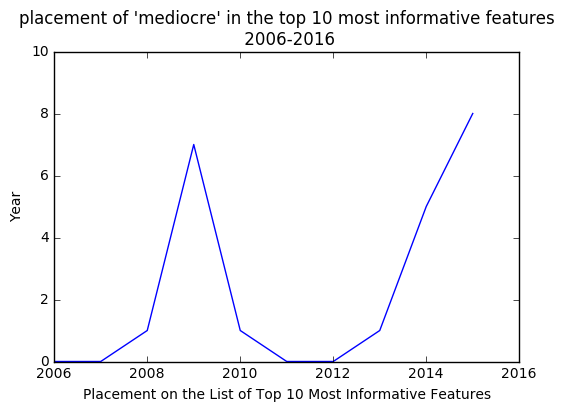

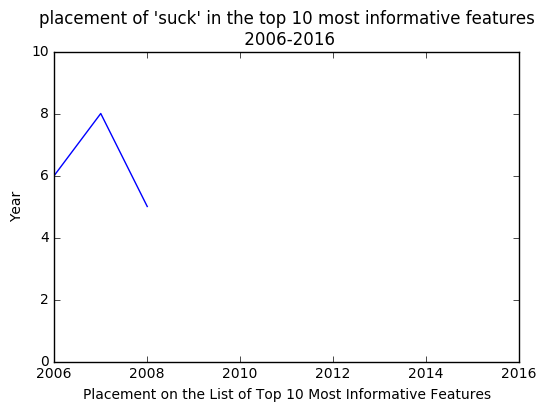

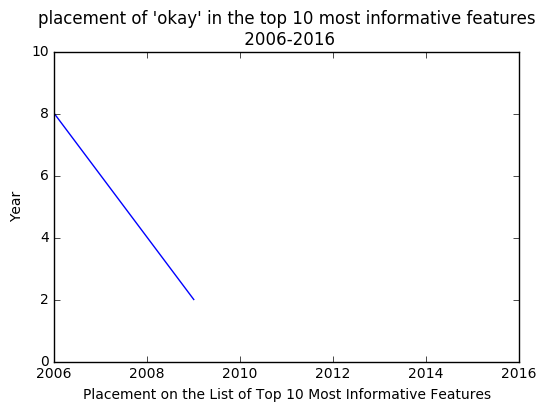

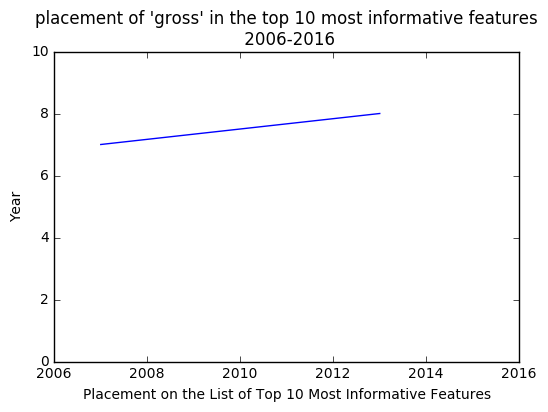

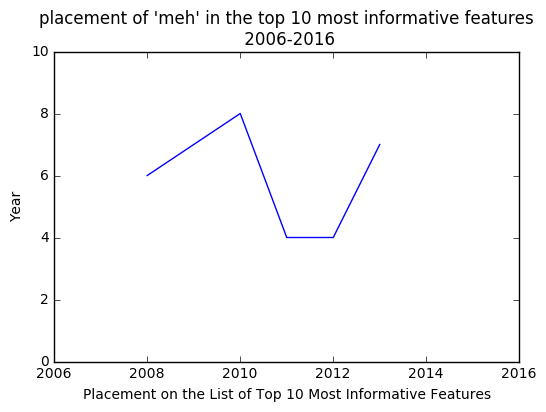

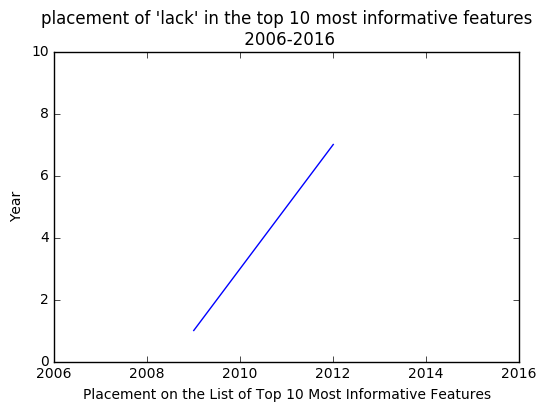

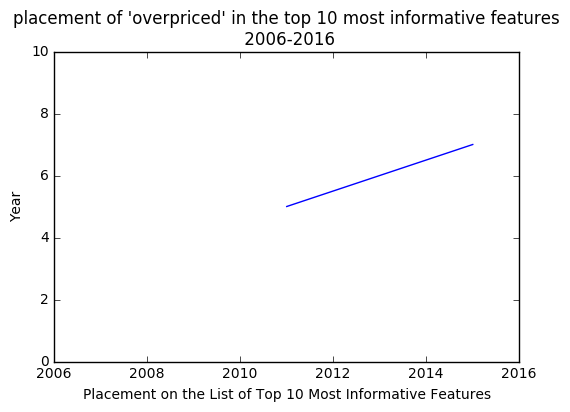

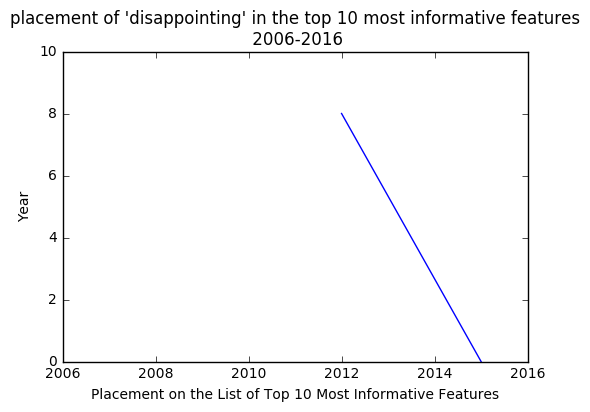

In [63]:
for word in negative.word.unique():
    sub_df = negative[negative.word == word]
    sub_df = sub_df.sort_values(by = 'year')
    if sub_df.shape[0] > 1:
        plt.plot(sub_df.year, sub_df.strength, label = word)
        plt.xlabel('Placement on the List of Top 10 Most Informative Features')
        plt.ylabel('Year')
        plt.xlim([2006,2016])
        plt.ylim([0, 10])
        plt.title('placement of \'' + word + '\' in the top 10 most informative features\n 2006-2016')
        plt.show()
    else:
        continue

So, we see a few trends here, some words appear quite often, others less so. Let's look at the words in here by the last time that they appeared in the top 10 most informative features. That should help us to identify the most 'outmoded' words in the dataset.

In [61]:
print('Positive')
print('____________________')
for word in positive.word.unique():
    sub_df = positive[positive.word == word]
    latest = sub_df[sub_df.year == max(sub_df.year)]
    print(latest.word.values, latest.year.values)
    
print('Negative')
print('____________________')
for word in negative.word.unique():
    sub_df = negative[negative.word == word]
    latest = sub_df[sub_df.year == max(sub_df.year)]
    print(latest.word.values, latest.year.values)

['perfect'] [2016]
['definitely'] [2016]
['awesome'] [2016]
['happy'] [2016]
['excellent'] [2016]
['best'] [2016]
['love'] [2016]
['amazing'] [2016]
['delicious'] [2016]
['hot'] [2006]
['fun'] [2006]
['friendly'] [2014]
['favorite'] [2015]
['great'] [2008]
['good'] [2015]
['helpful'] [2009]
['fantastic'] [2014]
['wonderful'] [2011]
['reasonable'] [2011]
['terrible'] [2016]
['rude'] [2016]
['awful'] [2016]
['horrible'] [2016]
['bad'] [2016]
['bland'] [2016]
['ok'] [2016]
['disappointed'] [2016]
['poor'] [2016]
['mediocre'] [2015]
['minute'] [2006]
['edible'] [2006]
['suck'] [2008]
['okay'] [2009]
['disappointment'] [2007]
['gross'] [2013]
['meh'] [2013]
['lack'] [2012]
['dry'] [2009]
['sorry'] [2010]
['overpriced'] [2015]
['dirty'] [2012]
['disappointing'] [2015]
['tell'] [2014]


So, from this, it looks like the words 'hot', 'fun', 'great', and 'helpful' are the most outmoded positive words, while 'minute', 'edible', 'suck', 'okay', 'disapointment', and 'dry' are the most outmoded negative words. While this may sound like a trivial conclusion, understanding the trends in speech patterns can be a vital part of crafting an effective marketing campaign, and this is a simple example of such an exercise. Using adjectives that are no longer a part of the popular parlance could make a company seem disconnected from their target demographic, so knowing better how speech patterns are changing could be very useful to a company in creating a marketing strategy and message. 

What I've done here is a framework for what one could do in more depth with developed requirements. If I were running this project for, say, an Italian restaurant, I could limit my query to only businesses with tags associated with Italian restaurants to get a better understanding of how my patrons speak about Italian food. If I were a part of a large-scale company with a broad geographic spread, I could adjust the query to certain locations and account for regional variations in speech patterns. 

An interesting next step here might be to get an n-gram for each of the words we've identified. The n-gram would show us how prevalent the word is over time, thus allowing us to see how often the word is used out of the context of positive/negative reviews.